# LAB | Hyperparameter Tuning

**Load the data**

Finally step in order to maximize the performance on your Spaceship Titanic model.

The data can be found here:

https://raw.githubusercontent.com/data-bootcamp-v4/data/main/spaceship_titanic.csv

Metadata

https://github.com/data-bootcamp-v4/data/blob/main/spaceship_titanic.md

So far we've been training and evaluating models with default values for hyperparameters.

Today we will perform the same feature engineering as before, and then compare the best working models you got so far, but now fine tuning it's hyperparameters.

In [38]:
#Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import time
import scipy.stats as st

In [5]:
spaceship = pd.read_csv("https://raw.githubusercontent.com/data-bootcamp-v4/data/main/spaceship_titanic.csv")
spaceship.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Now perform the same as before:
- Feature Scaling
- Feature Selection


In [9]:

#your code here
spaceship.dropna(inplace=True)
def transform_values(cabin):
    return cabin[0]
spaceship['Cabin']=spaceship['Cabin'].apply(transform_values)
spaceship.drop(['PassengerId','Name'],axis=1,inplace=True)
categorical_cols = ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP']
other_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','Transported'] 
ohe = OneHotEncoder(sparse_output=False,)
ohe.fit(spaceship[categorical_cols])
categorical_cols_encoded = ohe.transform(spaceship[categorical_cols])
new_cat_df = pd.DataFrame(categorical_cols_encoded, columns=ohe.get_feature_names_out(categorical_cols), index=spaceship.index)
new_num_df=spaceship[other_cols]
new_spaceship_df=pd.concat([new_cat_df,new_num_df],axis=1)
X = new_spaceship_df.drop(columns=['Transported'])
y = new_spaceship_df['Transported']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
normalizer = MinMaxScaler()
normalizer.fit(X_train)
X_train_norm = normalizer.transform(X_train)
X_test_norm = normalizer.transform(X_test)
X_train_norm = pd.DataFrame(X_train_norm, columns=X_train.columns, index=X_train.index )
X_test_norm = pd.DataFrame(X_test_norm, columns=X_test.columns, index=X_test.index)

- Now let's use the best model we got so far in order to see how it can improve when we fine tune it's hyperparameters.

In [14]:
#your code here

# Create and train the Gradient Boosting model
gb = GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)
gb.fit(X_train_norm, y_train)


GradientBoostingClassifier(random_state=42)

- Evaluate your model

 Accuracy: 0.8101361573373677

 Classification Report:
               precision    recall  f1-score   support

       False       0.84      0.76      0.80       653
        True       0.78      0.86      0.82       669

    accuracy                           0.81      1322
   macro avg       0.81      0.81      0.81      1322
weighted avg       0.81      0.81      0.81      1322



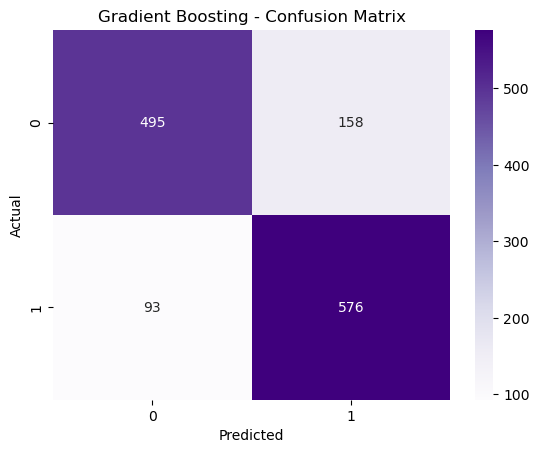

In [17]:
#your code here

# Predict on test set
y_pred_test_gb = gb.predict(X_test_norm)

# Accuracy and classification report
print(" Accuracy:", accuracy_score(y_test, y_pred_test_gb))
print("\n Classification Report:\n", classification_report(y_test, y_pred_test_gb))

# Confusion matrix
cm_gb = confusion_matrix(y_test, y_pred_test_gb)
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Purples')
plt.title("Gradient Boosting - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**Grid/Random Search**

For this lab we will use Grid Search.

- Define hyperparameters to fine tune.

In [25]:
#your code here
#Grid Search
# Hyperparameter grid
parameter_grid = {
    "n_estimators": [100, 200],
    "max_depth": [10, 30],
    "min_samples_split": [2, 10],
    "max_features": ["sqrt", "log2"]
}  


- Run Grid Search

In [40]:


gb = GradientBoostingClassifier(random_state=123)

# GridSearchCV setup
folds = 10
confidence_level = 0.95
gs = GridSearchCV(gb, param_grid=parameter_grid, cv=folds, verbose=1, scoring='accuracy', n_jobs=-1)

# Fit
start_time = time.time()
gs.fit(X_train_norm, y_train)
end_time = time.time()
gsearchtime=end_time - start_time
# Timing
print(f"\nTime taken: {end_time - start_time:.2f} seconds")

# Best results
print("\nBest hyperparameters found:", gs.best_params_)
print(f"Cross-validated best accuracy: {gs.best_score_:.4f}")

# Confidence interval
results_gs_df = pd.DataFrame(gs.cv_results_).sort_values(by="mean_test_score", ascending=False)
mean_score = results_gs_df.iloc[0]["mean_test_score"]
std_score = results_gs_df.iloc[0]["std_test_score"]
sem = std_score / np.sqrt(folds)
tc = st.t.ppf(1 - ((1 - confidence_level) / 2), df=folds - 1)
lower_bound = mean_score - tc * sem
upper_bound = mean_score + tc * sem

print(f"95% Confidence Interval for accuracy: ({lower_bound:.4f}, {mean_score:.4f}, {upper_bound:.4f})")

# Best model
best_model = gs.best_estimator_


Fitting 10 folds for each of 16 candidates, totalling 160 fits

Time taken: 146.19 seconds

Best hyperparameters found: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100}
Cross-validated best accuracy: 0.7901
95% Confidence Interval for accuracy: (0.7761, 0.7901, 0.8041)


- Evaluate your model


 Test Accuracy: 0.8063540090771558

 Classification Report:
               precision    recall  f1-score   support

       False       0.80      0.80      0.80       653
        True       0.81      0.81      0.81       669

    accuracy                           0.81      1322
   macro avg       0.81      0.81      0.81      1322
weighted avg       0.81      0.81      0.81      1322



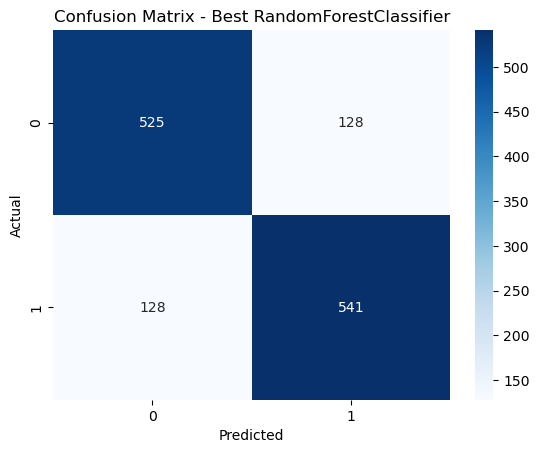

In [44]:

# Predict and evaluate
y_pred = best_model.predict(X_test_norm)
print("\n Test Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Best RandomForestClassifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()